In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
import tensorflow as tf
from collections import Counter
import shutil

In [9]:
# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
SIZE = 450
BATCH_SIZE = 64
EPOCHS = 50
NUM_CLASSES = len(os.listdir(train_dir))

In [10]:
# Resample function to balance each class to 500 samples
def resample_data(directory, target_count=500):
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for class_dir in class_dirs:
        class_path = os.path.join(directory, class_dir)
        images = glob(os.path.join(class_path, "*.jpg"))
        current_count = len(images)
        if current_count < target_count:
            # Augment the class to have `target_count` images
            for i in range(target_count - current_count):
                image = images[i % current_count]
                image_name = os.path.basename(image)
                new_image_name = f"aug_{i}_{image_name}"
                new_image_path = os.path.join(class_path, new_image_name)
                shutil.copy(image, new_image_path)
        elif current_count > target_count:
            # Reduce the class to `target_count` images
            for image in images[target_count:]:
                os.remove(image)
                
def resample_data1(directory, target_count=300):
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for class_dir in class_dirs:
        class_path = os.path.join(directory, class_dir)
        images = glob(os.path.join(class_path, "*.jpg"))
        current_count = len(images)
        if current_count < target_count:
            # Augment the class to have `target_count` images
            for i in range(target_count - current_count):
                image = images[i % current_count]
                image_name = os.path.basename(image)
                new_image_name = f"aug_{i}_{image_name}"
                new_image_path = os.path.join(class_path, new_image_name)
                shutil.copy(image, new_image_path)
        elif current_count > target_count:
            # Reduce the class to `target_count` images
            for image in images[target_count:]:
                os.remove(image)

In [11]:
# Resample training data
resample_data(train_dir)
resample_data1(val_dir)


# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(SIZE, SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(SIZE, SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(SIZE, SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)


Found 3500 images belonging to 7 classes.
Found 2100 images belonging to 7 classes.
Found 1515 images belonging to 7 classes.


In [12]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

# Load the VGG16 model without the top fully connected layers (include_top=False)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

# Freeze the base_model layers to prevent them from being trained
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

# Summary of the model
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 450, 450, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 450, 450, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 450, 450, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 225, 225, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 225, 225, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 225, 225, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 112, 112, 128)     0   

In [13]:
# Metrics callback for precision
class MetricsCallback(Callback):
    def __init__(self, val_generator):
        super(MetricsCallback, self).__init__()
        self.val_generator = val_generator

    def on_epoch_end(self, epoch, logs=None):
        y_true = self.val_generator.classes
        y_pred = self.model.predict(self.val_generator)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate precision only
        precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

        val_loss = logs['val_loss']
        val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions

        print(f'Epoch {epoch + 1} - '
              f'Validation Loss: {val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}, '
              f'Validation Precision: {precision:.4f}')
        
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=1000, restore_best_weights=True)

# Metrics callback
metrics_callback = MetricsCallback(val_generator)

In [14]:
# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, metrics_callback],
    verbose=2
)

Epoch 1/50
33/33 [==============================] - 23s 712ms/step
Epoch 1 - Validation Loss: 1.9372, Validation Accuracy: 0.2010, Validation Precision: 0.0875
55/55 - 123s - loss: 2.0192 - acc: 0.1374 - val_loss: 1.9372 - val_acc: 0.2010 - 123s/epoch - 2s/step
Epoch 2/50


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


33/33 [==============================] - 23s 721ms/step
Epoch 2 - Validation Loss: 1.9201, Validation Accuracy: 0.2590, Validation Precision: 0.1428
55/55 - 122s - loss: 1.9371 - acc: 0.1717 - val_loss: 1.9201 - val_acc: 0.2590 - 122s/epoch - 2s/step
Epoch 3/50
33/33 [==============================] - 23s 713ms/step
Epoch 3 - Validation Loss: 1.8775, Validation Accuracy: 0.2710, Validation Precision: 0.1068
55/55 - 121s - loss: 1.9121 - acc: 0.1934 - val_loss: 1.8775 - val_acc: 0.2710 - 121s/epoch - 2s/step
Epoch 4/50


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


33/33 [==============================] - 23s 720ms/step
Epoch 4 - Validation Loss: 1.8230, Validation Accuracy: 0.2948, Validation Precision: 0.1135
55/55 - 122s - loss: 1.8744 - acc: 0.2200 - val_loss: 1.8230 - val_acc: 0.2948 - 122s/epoch - 2s/step
Epoch 5/50


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


33/33 [==============================] - 24s 725ms/step
Epoch 5 - Validation Loss: 1.7825, Validation Accuracy: 0.3224, Validation Precision: 0.1199
55/55 - 122s - loss: 1.8503 - acc: 0.2266 - val_loss: 1.7825 - val_acc: 0.3224 - 122s/epoch - 2s/step
Epoch 6/50


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


33/33 [==============================] - 23s 720ms/step
Epoch 6 - Validation Loss: 1.7593, Validation Accuracy: 0.2862, Validation Precision: 0.1557
55/55 - 122s - loss: 1.8155 - acc: 0.2449 - val_loss: 1.7593 - val_acc: 0.2862 - 122s/epoch - 2s/step
Epoch 7/50
33/33 [==============================] - 23s 711ms/step
Epoch 7 - Validation Loss: 1.7308, Validation Accuracy: 0.3248, Validation Precision: 0.1067
55/55 - 122s - loss: 1.7737 - acc: 0.2711 - val_loss: 1.7308 - val_acc: 0.3248 - 122s/epoch - 2s/step
Epoch 8/50
33/33 [==============================] - 23s 712ms/step
Epoch 8 - Validation Loss: 1.7153, Validation Accuracy: 0.3348, Validation Precision: 0.1702
55/55 - 122s - loss: 1.7729 - acc: 0.2714 - val_loss: 1.7153 - val_acc: 0.3348 - 122s/epoch - 2s/step
Epoch 9/50
33/33 [==============================] - 23s 712ms/step
Epoch 9 - Validation Loss: 1.6921, Validation Accuracy: 0.3338, Validation Precision: 0.1390
55/55 - 122s - loss: 1.7586 - acc: 0.2674 - val_loss: 1.6921 - va

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


33/33 [==============================] - 23s 705ms/step
Epoch 21 - Validation Loss: 1.6124, Validation Accuracy: 0.3771, Validation Precision: 0.1338
55/55 - 120s - loss: 1.6422 - acc: 0.3251 - val_loss: 1.6124 - val_acc: 0.3771 - 120s/epoch - 2s/step
Epoch 22/50
33/33 [==============================] - 23s 704ms/step
Epoch 22 - Validation Loss: 1.6001, Validation Accuracy: 0.3519, Validation Precision: 0.1499
55/55 - 120s - loss: 1.6212 - acc: 0.3249 - val_loss: 1.6001 - val_acc: 0.3519 - 120s/epoch - 2s/step
Epoch 23/50
33/33 [==============================] - 23s 704ms/step
Epoch 23 - Validation Loss: 1.5998, Validation Accuracy: 0.4048, Validation Precision: 0.1513
55/55 - 120s - loss: 1.6203 - acc: 0.3420 - val_loss: 1.5998 - val_acc: 0.4048 - 120s/epoch - 2s/step
Epoch 24/50
33/33 [==============================] - 23s 704ms/step
Epoch 24 - Validation Loss: 1.6203, Validation Accuracy: 0.3552, Validation Precision: 0.1426
55/55 - 119s - loss: 1.6161 - acc: 0.3471 - val_loss: 1.62

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


33/33 [==============================] - 23s 704ms/step
Epoch 32 - Validation Loss: 1.5636, Validation Accuracy: 0.3952, Validation Precision: 0.1302
55/55 - 120s - loss: 1.5673 - acc: 0.3669 - val_loss: 1.5636 - val_acc: 0.3952 - 120s/epoch - 2s/step
Epoch 33/50
33/33 [==============================] - 23s 705ms/step
Epoch 33 - Validation Loss: 1.5407, Validation Accuracy: 0.4214, Validation Precision: 0.1474
55/55 - 119s - loss: 1.5691 - acc: 0.3786 - val_loss: 1.5407 - val_acc: 0.4214 - 119s/epoch - 2s/step
Epoch 34/50
33/33 [==============================] - 23s 704ms/step
Epoch 34 - Validation Loss: 1.5520, Validation Accuracy: 0.4019, Validation Precision: 0.1161
55/55 - 120s - loss: 1.5528 - acc: 0.3766 - val_loss: 1.5520 - val_acc: 0.4019 - 120s/epoch - 2s/step
Epoch 35/50
33/33 [==============================] - 23s 704ms/step
Epoch 35 - Validation Loss: 1.5460, Validation Accuracy: 0.4157, Validation Precision: 0.1499
55/55 - 119s - loss: 1.5372 - acc: 0.3834 - val_loss: 1.54

In [15]:
# Calculate precision, recall, and f1 score after training
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

print(f'Final Precision: {precision:.4f}')
print(f'Final Recall: {recall:.4f}')
print(f'Final F1 Score: {f1_score:.4f}')

33/33 [==============================] - 24s 724ms/step
Final Precision: 0.1562
Final Recall: 0.1424
Final F1 Score: 0.1278


24/24 [==============================] - 29s 1s/step - loss: 1.7426 - acc: 0.2812
Test accuracy: 0.28118813037872314


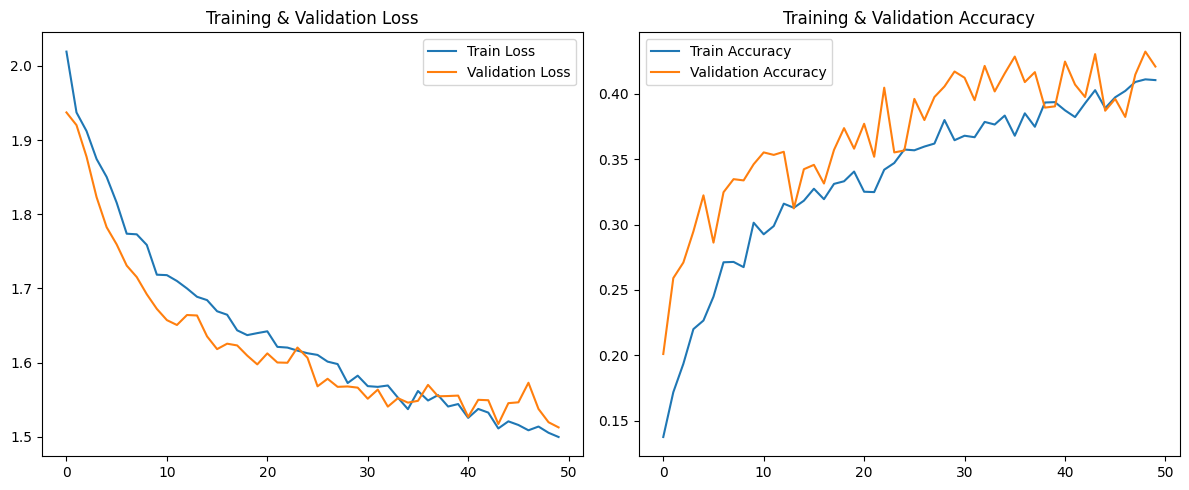

In [16]:
# Evaluate the model on the test set
test_score = model.evaluate(test_generator)
print('Test accuracy:', test_score[1])

# Plot the training and validation accuracy and loss at each epoch
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Training & Validation Loss
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].legend()
axs[0].set_title('Training & Validation Loss')

# Plot Training & Validation Accuracy
axs[1].plot(history.history['acc'], label='Train Accuracy')
axs[1].plot(history.history['val_acc'], label='Validation Accuracy')
axs[1].legend()
axs[1].set_title('Training & Validation Accuracy')

plt.tight_layout()
plt.show()

55/55 [==============================] - 86s 2s/step


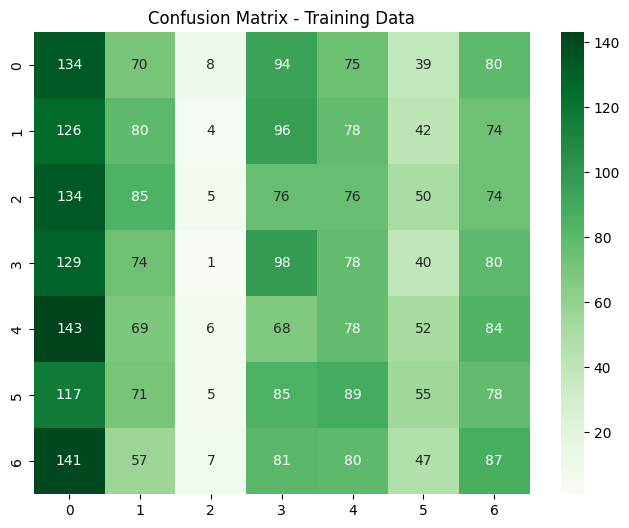

33/33 [==============================] - 23s 707ms/step


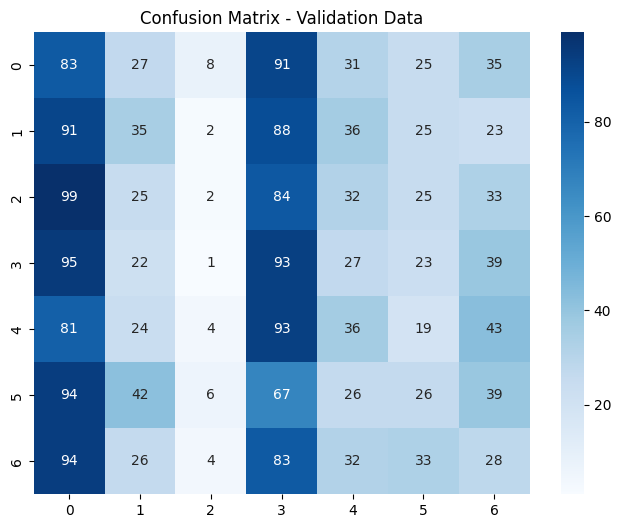

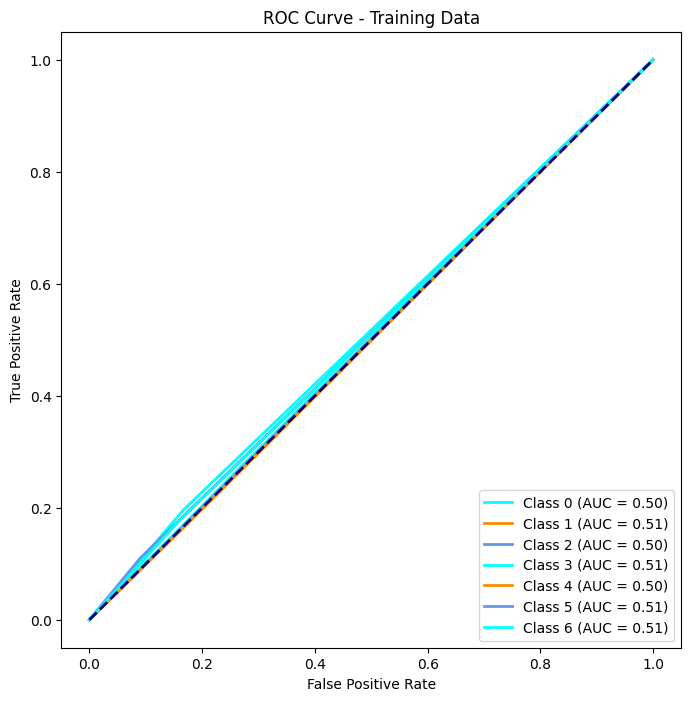

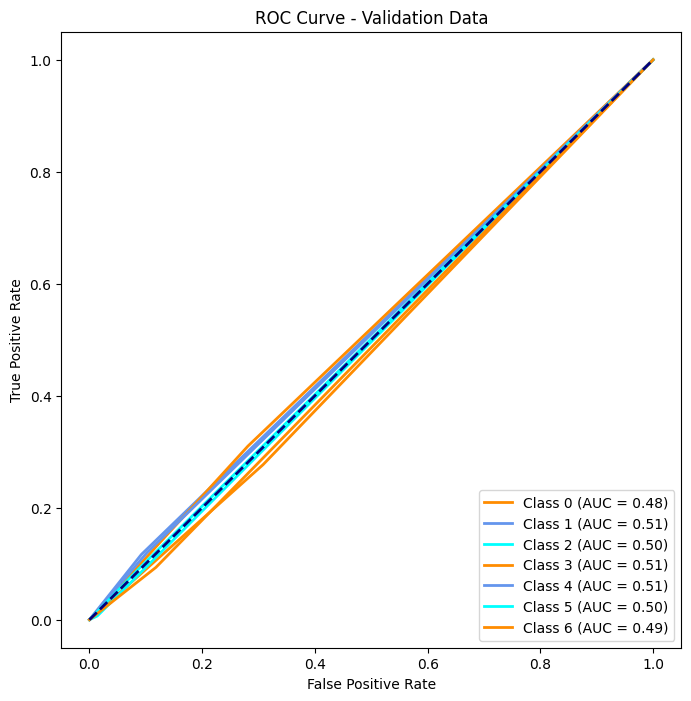

In [17]:
# Confusion matrix for training data
y_train_true = train_generator.classes
y_train_pred = model.predict(train_generator)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
cm_train = confusion_matrix(y_train_true, y_train_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Training Data')
plt.show()

# Confusion matrix for validation data
y_val_true = val_generator.classes
y_val_pred = model.predict(val_generator)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
cm_val = confusion_matrix(y_val_true, y_val_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Data')
plt.show()

# AUC-ROC curve for training data
y_train_true_binary = label_binarize(y_train_true, classes=np.unique(y_train_true))
y_train_pred_binary = label_binarize(y_train_pred_classes, classes=np.unique(y_train_true))

fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()

for i in range(NUM_CLASSES):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_true_binary[:, i], y_train_pred_binary[:, i])
    roc_auc_train[i] = roc_auc_score(y_train_true_binary[:, i], y_train_pred_binary[:, i])

plt.figure(figsize=(8, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr_train[i], tpr_train[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc_train[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Data')
plt.legend(loc='lower right')
plt.show()

# AUC-ROC curve for validation data
y_val_true_binary = label_binarize(y_val_true, classes=np.unique(y_val_true))
y_val_pred_binary = label_binarize(y_val_pred_classes, classes=np.unique(y_val_true))

fpr_val = dict()
tpr_val = dict()
roc_auc_val = dict()

for i in range(NUM_CLASSES):
    fpr_val[i], tpr_val[i], _ = roc_curve(y_val_true_binary[:, i], y_val_pred_binary[:, i])
    roc_auc_val[i] = roc_auc_score(y_val_true_binary[:, i], y_val_pred_binary[:, i])

plt.figure(figsize=(8, 8))
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr_val[i], tpr_val[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc_val[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Data')
plt.legend(loc='lower right')
plt.show()
